# CorrectnessCheck

Here, I attempt to expedite the process of checking the correctness of OCR output.

## Initial Setup

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr

/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr


Here, I install Tesseract for all available languages. It's a little sad that I have to do this, but that's what OOP does for you: If you want to use a class that has a giant package as a dependency, then you have to install the giant package.

In [ ]:
# The capture command is used here to minimize visual clutter.
%%capture
!sudo apt-get install tesseract-ocr-all
!pip3 install pytesseract
!pip install langdetect
!pip install pdf2image
!apt-get install poppler-utils

These are the packages that I will use:

In [ ]:
from tesseract_manager import Text, WeightTracker
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from numpy.random import default_rng
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
import warnings

## Globals

In [ ]:
TEXTS_ROOT = '/content/drive/My Drive/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST/MixLangTest6'

## Getting Text objects

In the process of parsing the texts, corresponding Text objects have been serialized and saved in the file system. Here, I merely recover them from a directory.

In [ ]:
def get_texts(path):
  """Returns a list of pairs of Text objects with their corresponding
  parent directories found in a recursive search of the directory
  specified by PATH.
  Warning: If there are large serialized
  objects in the directory, they may slow down this process
  considerably even if they are not Text objects.
  Warning: Only recognizes files with the extension 'pickle'.
  """
  ret = list()
  for root, dirs, files in os.walk(path):
    for file in files:
      if os.path.splitext(file)[1] == '.pickle':
        with open(os.path.join(root, file), 'rb') as dbfile:
          obj = pickle.load(dbfile)
          if isinstance(obj, Text):
            ret.append((obj, root))
  return ret

In [ ]:
texts = get_texts(os.path.join(TEXTS_ROOT))
texts

[(<tesseract_manager.Text at 0x7fcf96f26bd0>,
  '/content/drive/My Drive/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST/MixLangTest6/MixLangTest6_0'),
 (<tesseract_manager.Text at 0x7fcf9678bd10>,
  '/content/drive/My Drive/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST/MixLangTest6/MixLangTest6_1'),
 (<tesseract_manager.Text at 0x7fcf966fae90>,
  '/content/drive/My Drive/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST/MixLangTest6/MixLangTest6_2'),
 (<tesseract_manager.Text at 0x7fcf965eb0d0>,
  '/content/drive/My Drive/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST/MixLangTest6/MixLangTest6_3'),
 (<tesseract_manager.Text at 0x7fcf965b1b90>,
  '/content/drive/My Drive/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST/MixLangTest6/MixLangTest6_4'),
 (<tesseract_manager.Text at 0x7fcf9a9bcb10>,
  '/content/drive/My Drive/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST/MixLangTest6/MixLangTest6_5'),
 (<tesseract_manager.Text at 0x7fcf95b12b90>,
  '/content/drive/My Drive/AWCA/Colab_notebooks/

In [ ]:
texts[0][0].page_metadata[0].head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,3292,2309,-1,NaN
1,2,1,1,0,0,0,243,0,3049,403,-1,NaN
2,3,1,1,1,0,0,243,0,3049,403,-1,NaN
3,4,1,1,1,1,0,243,0,3049,403,-1,NaN
4,5,1,1,1,1,1,243,0,3049,403,95,


## TextAccuracyEstimator

Specifies the logic required to estimate the proportion of words correctly parsed. (Ultimately, it is up to the user to determine correctness.)

In [ ]:
warnings.warn('animal {}'.format(str({1: 'a', 2: 'b'})))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: animal {1: 'a', 2: 'b'}
  """Entry point for launching an IPython kernel.


In [ ]:
class TextAccuracyEstimator:
  """Specifies the logic required to estimate the proportion of
  words correctly read. (Ultimately, it is up to the user to
  determine correctness.)
  """
  def __init__(self, root, text, random):
    """Initializes a TextAccuracyEstimator that analyzes the
    accuracy of the output produced by TEXT.
    ROOT - the directory in which TEXT and its corresponding images
           live
    TEXT - the Text object that managed the analysis of the images
    RANDOM - the Numpy default_random object that determines the
           samples taken by this TextAccuracyEstimator
    """
    self.accuracies = list()
    self._text = text
    self._page_paths = [
        os.path.join(root, 'images', path) for path in self._text.page_paths
        if path.endswith('ppm')
    ]
    self.random = random
  def run(self, n):
    """Collects accuracy data based on N requests for user
    input.
    """
    while len(self.accuracies) < n:
      page_idx = self.random.integers(len(self._page_paths))
      metadata = self._text.page_metadata[page_idx]
      page = Image.open(self._page_paths[page_idx])
      word_idx = self.random.choice(metadata.index)
      row = metadata.loc[word_idx]
      if (pd.isna(row.text)):
        continue
      fig, axes = plt.subplots(1, 4)
      fig.set_figwidth(15)
      for i in range(4):
        if row.left < page.size[0] and row.top < page.size[1]:
          word = page.crop(
                (row.left, row.top, row.left+row.width, row.top+row.height))
          try:
            axes[i].imshow(word)
          except:
            warnings.warn('Could not render {}'.format(str(word)))
        page = page.rotate(90, expand=True)
      plt.show(block=False)
      plt.pause(0.1)
      display(Markdown('<h1>&nbsp;&nbsp;&nbsp;&nbsp;{}</h1>'.format(row.text)))
      self.accuracies.append('y' in input('Is this correct (y/n)?\n').lower())
  def mean(self):
    """Returns the estimated mean accuracy for this text."""
    return sum(self.accuracies) / len(self.accuracies)

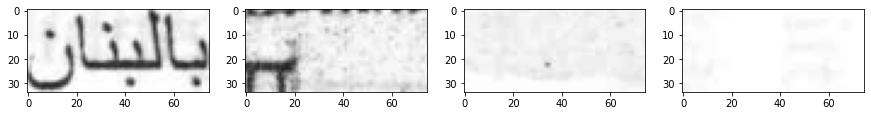

<h1>&nbsp;&nbsp;&nbsp;&nbsp;بالبنان</h1>

Is this correct (y/n)?
y


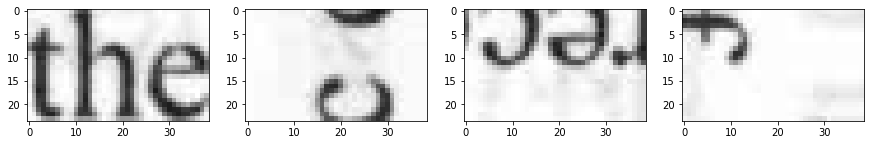

<h1>&nbsp;&nbsp;&nbsp;&nbsp;the</h1>

Is this correct (y/n)?
y


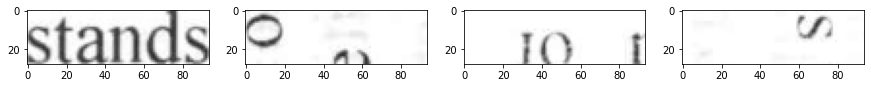

<h1>&nbsp;&nbsp;&nbsp;&nbsp;stands</h1>

Is this correct (y/n)?
y


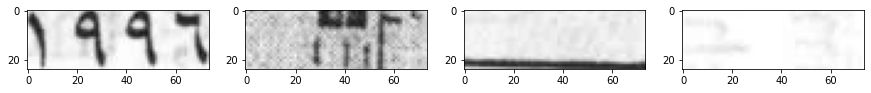

<h1>&nbsp;&nbsp;&nbsp;&nbsp;117١</h1>

Is this correct (y/n)?
n


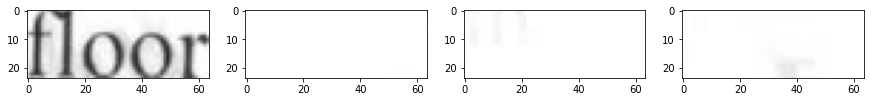

<h1>&nbsp;&nbsp;&nbsp;&nbsp;floor</h1>

Is this correct (y/n)?
y


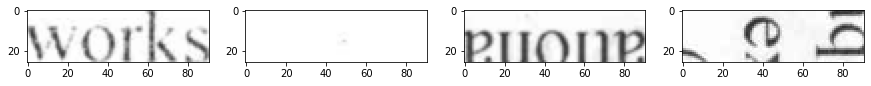

<h1>&nbsp;&nbsp;&nbsp;&nbsp;works</h1>

Is this correct (y/n)?
y


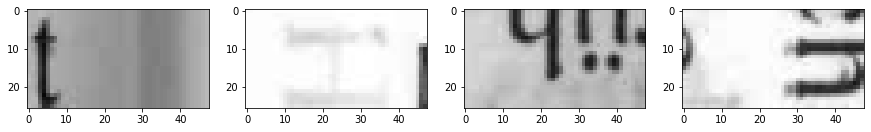

<h1>&nbsp;&nbsp;&nbsp;&nbsp; </h1>

Is this correct (y/n)?
n


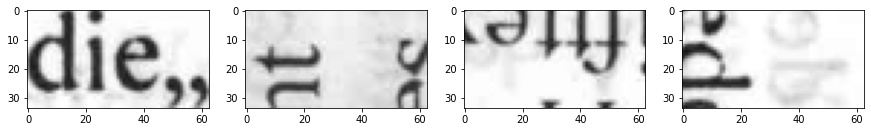

<h1>&nbsp;&nbsp;&nbsp;&nbsp;die,,</h1>

Is this correct (y/n)?
y


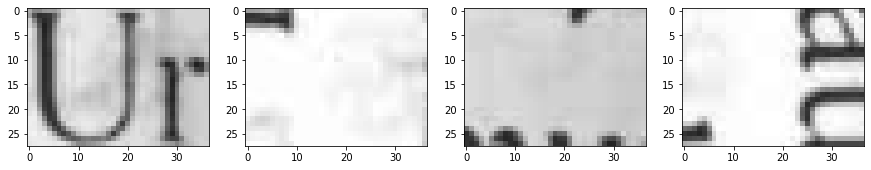

<h1>&nbsp;&nbsp;&nbsp;&nbsp;Ur</h1>

Is this correct (y/n)?
y


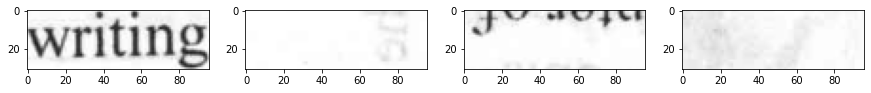

<h1>&nbsp;&nbsp;&nbsp;&nbsp;writing</h1>

Is this correct (y/n)?
y


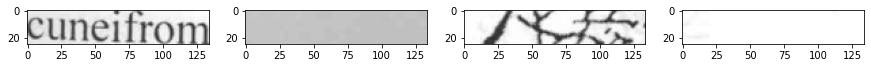

<h1>&nbsp;&nbsp;&nbsp;&nbsp;cuneifrom</h1>

Is this correct (y/n)?
y


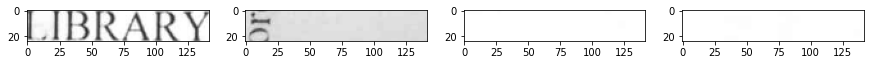

<h1>&nbsp;&nbsp;&nbsp;&nbsp;LIBRARY</h1>

Is this correct (y/n)?
y


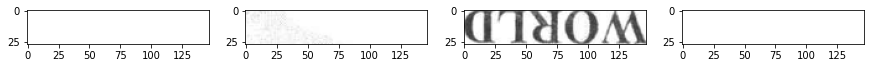

<h1>&nbsp;&nbsp;&nbsp;&nbsp;dTYOM</h1>

Is this correct (y/n)?
n


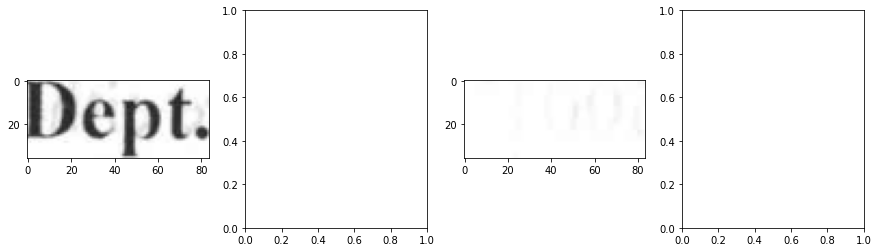

<h1>&nbsp;&nbsp;&nbsp;&nbsp;Dept.</h1>

Is this correct (y/n)?
y


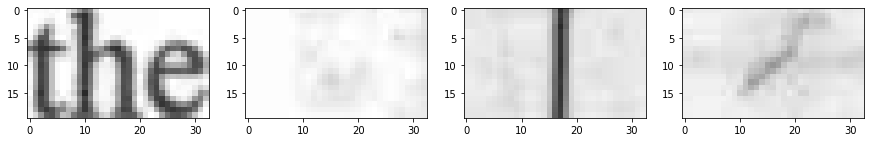

<h1>&nbsp;&nbsp;&nbsp;&nbsp;the</h1>

Is this correct (y/n)?
y


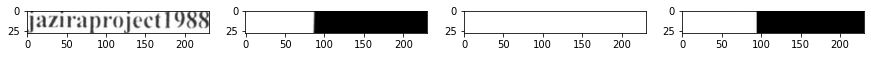

<h1>&nbsp;&nbsp;&nbsp;&nbsp;jaziraproject1988</h1>

Is this correct (y/n)?
y


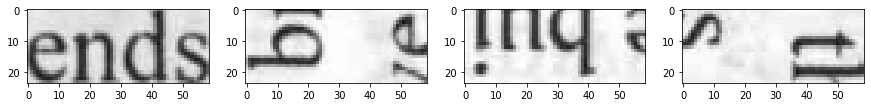

<h1>&nbsp;&nbsp;&nbsp;&nbsp;ends</h1>

Is this correct (y/n)?
y


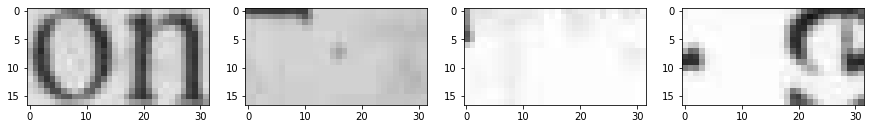

<h1>&nbsp;&nbsp;&nbsp;&nbsp;on</h1>

Is this correct (y/n)?
y


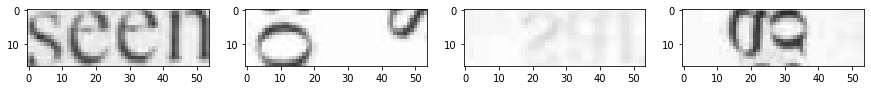

<h1>&nbsp;&nbsp;&nbsp;&nbsp;seen</h1>

Is this correct (y/n)?
y


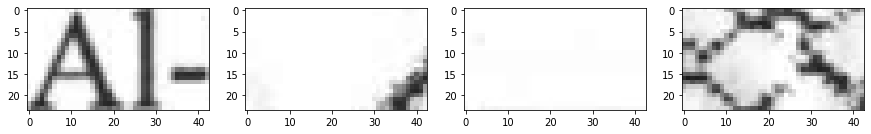

<h1>&nbsp;&nbsp;&nbsp;&nbsp;لك</h1>

Is this correct (y/n)?
n


In [ ]:
(TextAccuracyEstimator(texts[0][1], texts[0][0], default_rng(23))).run(20)

It looks like we have it working.

## CrossTextAnalysis

In [ ]:
class CrossTextAnalysis:
  """Manages and captures data generated from the analysis
  of OCR output across texts in a directory.
  """
  def __init__(self, root, random):
    """Initializes a CrossTextAnalysis object that stores
    accuracy data from Texts found in ROOT and its
    subdirectories.
    ROOT - the directory in which to search for Texts
    RANDOM - the Generator object that determines sampling
           behavior
    """
    self.root = root
    self.random = random
    self.texts = list()
    self.accuracy_estimators = list()
  def run(self, n):
    """Collects accuracy data by taking N sample words from each
    Text in ROOT.
    """
    for text, dir in get_texts(self.root):
      self.texts.append(text)
      estimator = TextAccuracyEstimator(dir, text, self.random)
      self.accuracy_estimators.append(estimator)
      estimator.run(n)
  def accuracies(self):
    """Returns the sequence of estimated accuracies across texts.
    """
    return [estimator.mean() for estimator in self.accuracy_estimators]
  def mean(self):
    """Returns the mean accuracy across texts, such that each
    texts has equal weight regardless of its size.
    """
    return sum(self.accuracies()) / len(self.accuracy_estimators)
  def hist(self):
    """Displays a the frequency distribution of accuracies across
    texts.
    """
    plt.hist(self.accuracies())
    plt.xlabel('Accuracy')
    plt.title('Distribution of OCR Accuracy by Text')
    plt.show(block=False)

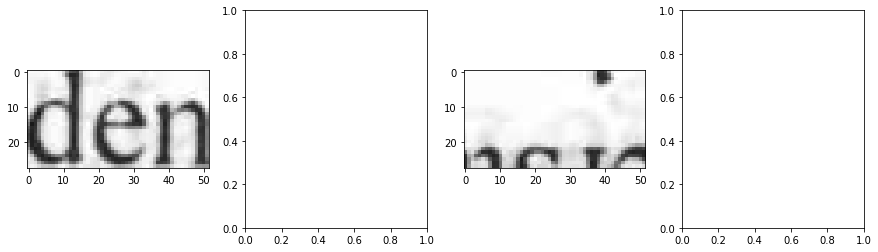

<h1>&nbsp;&nbsp;&nbsp;&nbsp;den</h1>

Is this correct (y/n)?
y


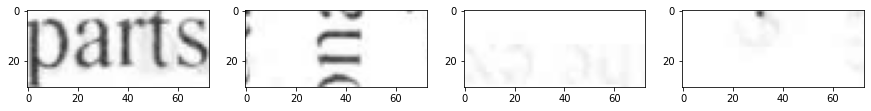

<h1>&nbsp;&nbsp;&nbsp;&nbsp;parts</h1>

Is this correct (y/n)?
y


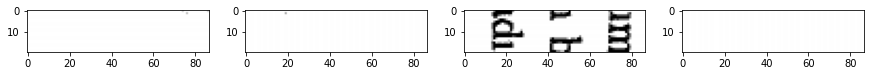

<h1>&nbsp;&nbsp;&nbsp;&nbsp;/пнонхх</h1>

Is this correct (y/n)?
n


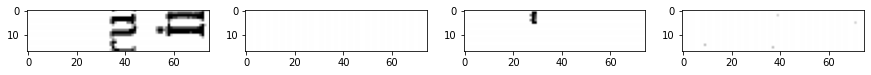

<h1>&nbsp;&nbsp;&nbsp;&nbsp;5.291-296.</h1>

Is this correct (y/n)?
n


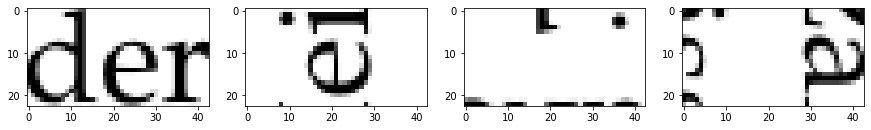

<h1>&nbsp;&nbsp;&nbsp;&nbsp;der</h1>

Is this correct (y/n)?
y


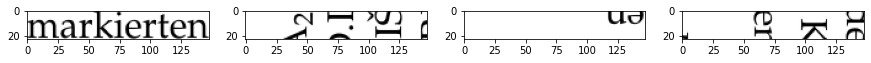

<h1>&nbsp;&nbsp;&nbsp;&nbsp;markierten</h1>

Is this correct (y/n)?
y


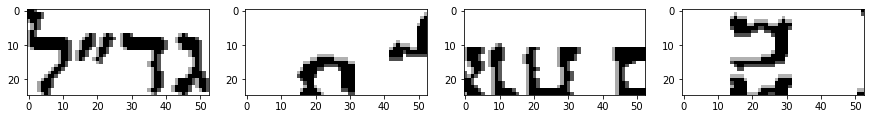

<h1>&nbsp;&nbsp;&nbsp;&nbsp;גד'"ל</h1>

Is this correct (y/n)?
y


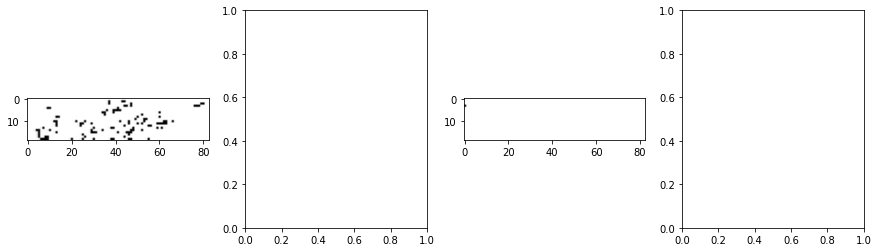

<h1>&nbsp;&nbsp;&nbsp;&nbsp; </h1>

Is this correct (y/n)?
y


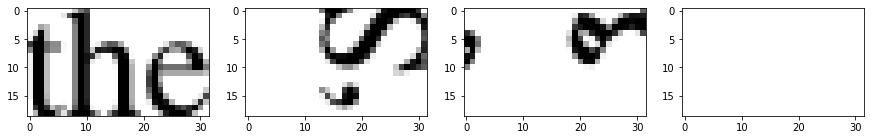

<h1>&nbsp;&nbsp;&nbsp;&nbsp;the</h1>

Is this correct (y/n)?
y


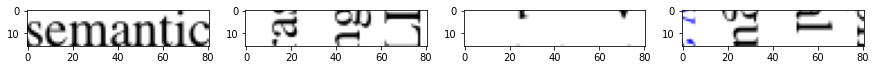

<h1>&nbsp;&nbsp;&nbsp;&nbsp;semantic</h1>

Is this correct (y/n)?
y


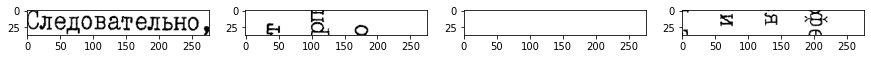

<h1>&nbsp;&nbsp;&nbsp;&nbsp;Следовательно,</h1>

Is this correct (y/n)?
y


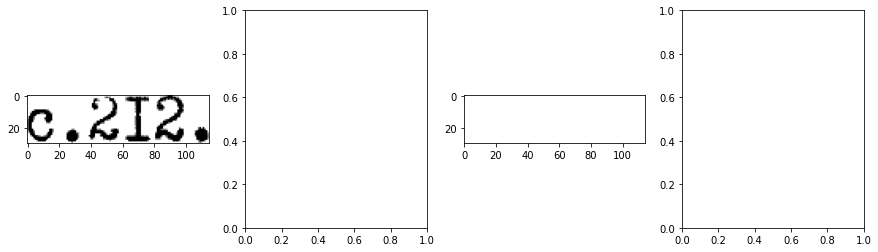

<h1>&nbsp;&nbsp;&nbsp;&nbsp;с.<18.</h1>

Is this correct (y/n)?
n


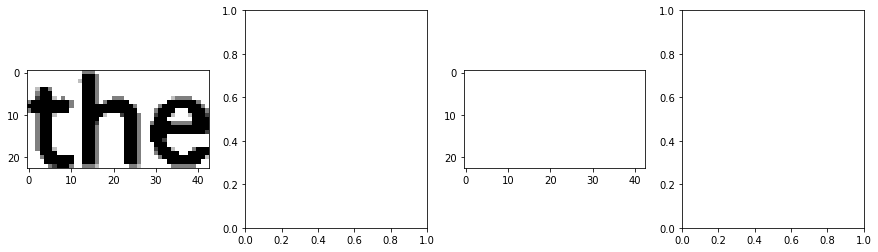

<h1>&nbsp;&nbsp;&nbsp;&nbsp;the</h1>

Is this correct (y/n)?
y


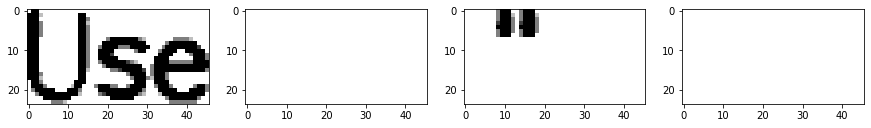

<h1>&nbsp;&nbsp;&nbsp;&nbsp;Use</h1>

Is this correct (y/n)?
y


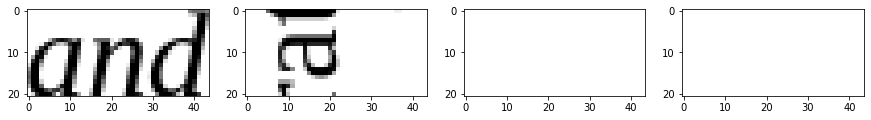

<h1>&nbsp;&nbsp;&nbsp;&nbsp;and</h1>

Is this correct (y/n)?
y


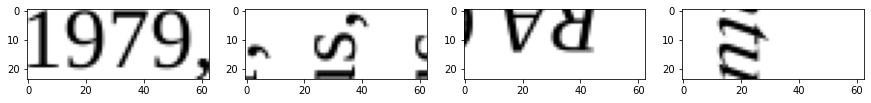

<h1>&nbsp;&nbsp;&nbsp;&nbsp;1979,</h1>

Is this correct (y/n)?
y


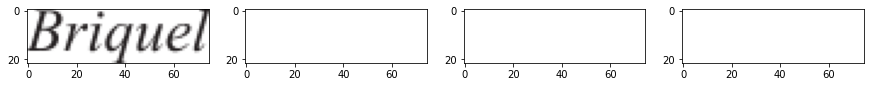

<h1>&nbsp;&nbsp;&nbsp;&nbsp;Briquel</h1>

Is this correct (y/n)?
y


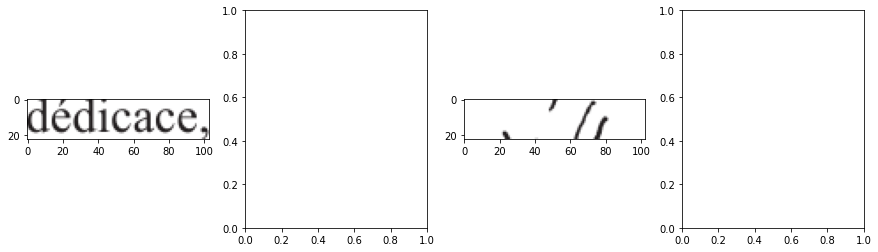

<h1>&nbsp;&nbsp;&nbsp;&nbsp;dédicace,</h1>

Is this correct (y/n)?
y


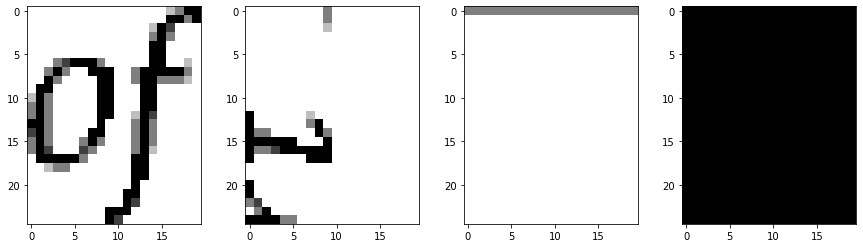

<h1>&nbsp;&nbsp;&nbsp;&nbsp;of</h1>

Is this correct (y/n)?
y


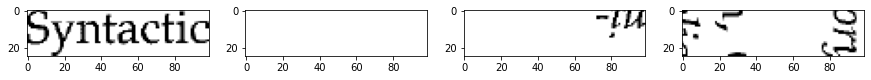

<h1>&nbsp;&nbsp;&nbsp;&nbsp;Syntactic</h1>

Is this correct (y/n)?
y


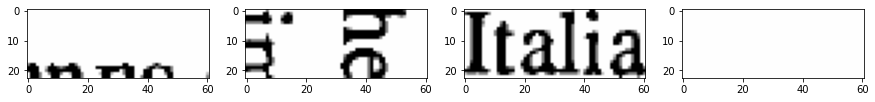

<h1>&nbsp;&nbsp;&nbsp;&nbsp;Italia</h1>

Is this correct (y/n)?
y


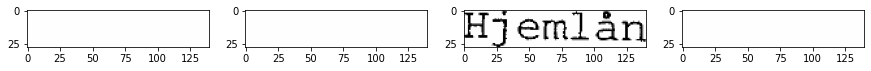

<h1>&nbsp;&nbsp;&nbsp;&nbsp;Hjemlån</h1>

Is this correct (y/n)?
y


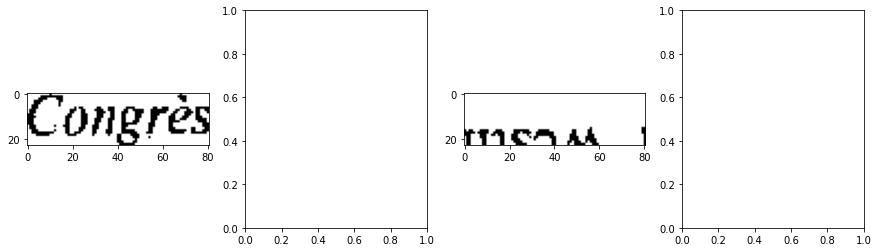

<h1>&nbsp;&nbsp;&nbsp;&nbsp;Congrés</h1>

Is this correct (y/n)?
y


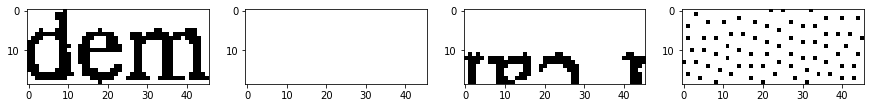

<h1>&nbsp;&nbsp;&nbsp;&nbsp;dem</h1>

Is this correct (y/n)?
y


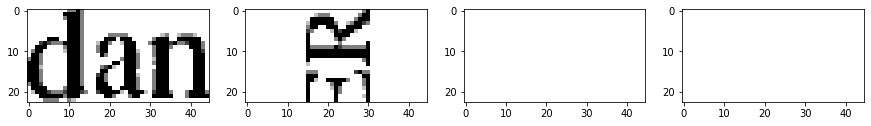

<h1>&nbsp;&nbsp;&nbsp;&nbsp;dan</h1>

Is this correct (y/n)?
y


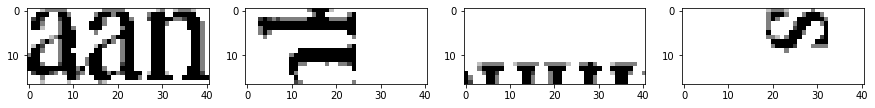

<h1>&nbsp;&nbsp;&nbsp;&nbsp;aan</h1>

Is this correct (y/n)?
y


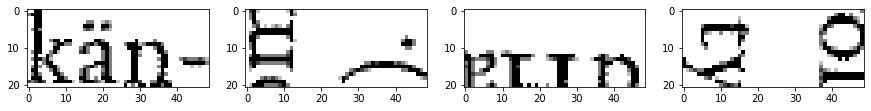

<h1>&nbsp;&nbsp;&nbsp;&nbsp;kän-</h1>

Is this correct (y/n)?
y


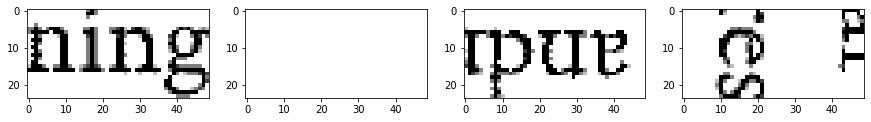

<h1>&nbsp;&nbsp;&nbsp;&nbsp;ning</h1>

Is this correct (y/n)?
y


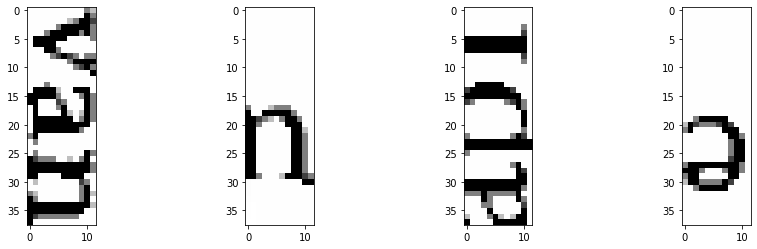

<h1>&nbsp;&nbsp;&nbsp;&nbsp;van</h1>

Is this correct (y/n)?
y


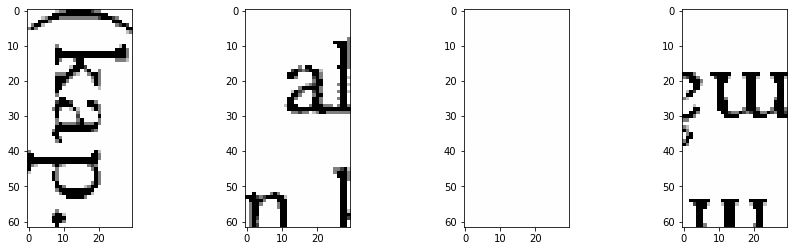

<h1>&nbsp;&nbsp;&nbsp;&nbsp;(kap.</h1>

Is this correct (y/n)?
y


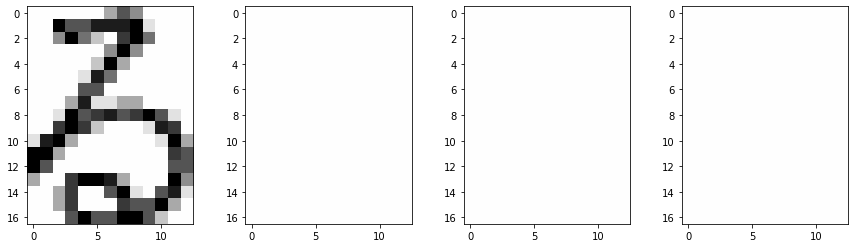

<h1>&nbsp;&nbsp;&nbsp;&nbsp;る</h1>

Is this correct (y/n)?
y


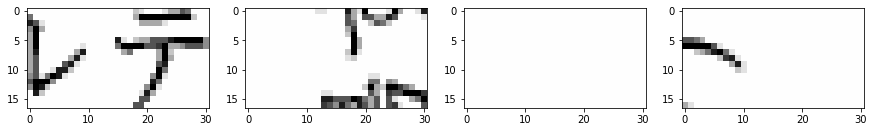

<h1>&nbsp;&nbsp;&nbsp;&nbsp;テ</h1>

Is this correct (y/n)?
y


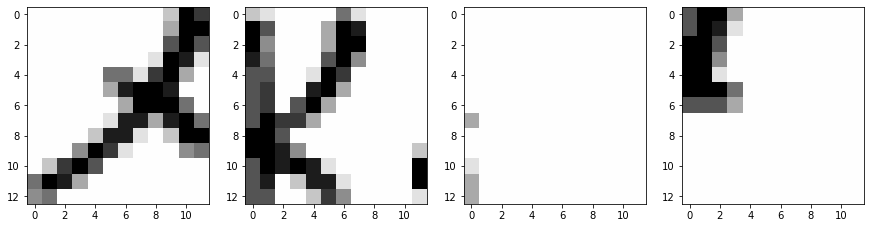

<h1>&nbsp;&nbsp;&nbsp;&nbsp;エネ</h1>

Is this correct (y/n)?
n


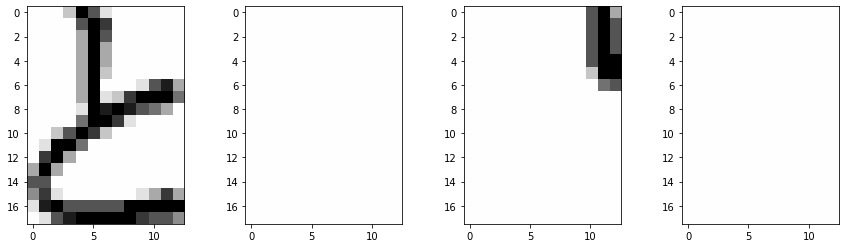

<h1>&nbsp;&nbsp;&nbsp;&nbsp;の</h1>

Is this correct (y/n)?
n


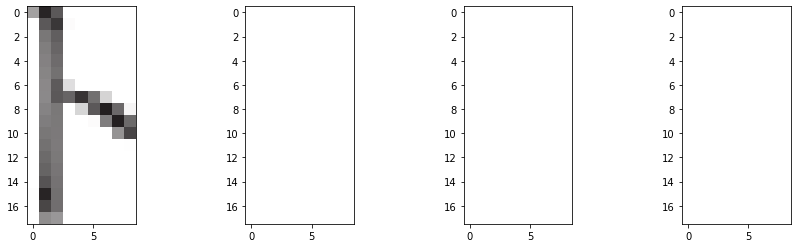

<h1>&nbsp;&nbsp;&nbsp;&nbsp;ト</h1>

Is this correct (y/n)?
y


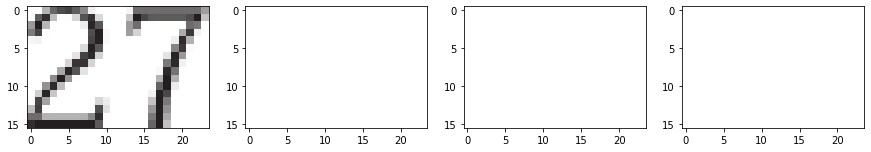

<h1>&nbsp;&nbsp;&nbsp;&nbsp;27</h1>

Is this correct (y/n)?
y


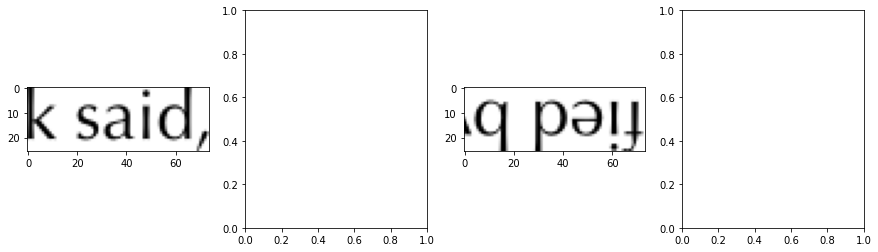

<h1>&nbsp;&nbsp;&nbsp;&nbsp;said,</h1>

Is this correct (y/n)?
y


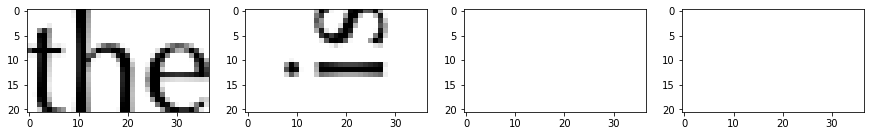

<h1>&nbsp;&nbsp;&nbsp;&nbsp;the</h1>

Is this correct (y/n)?
y


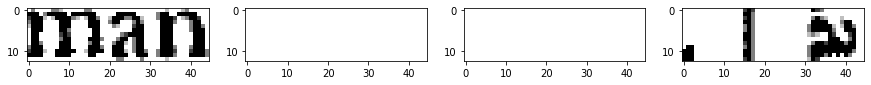

<h1>&nbsp;&nbsp;&nbsp;&nbsp;mana</h1>

Is this correct (y/n)?
n


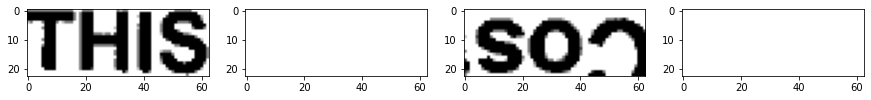

<h1>&nbsp;&nbsp;&nbsp;&nbsp;THIS</h1>

Is this correct (y/n)?
y


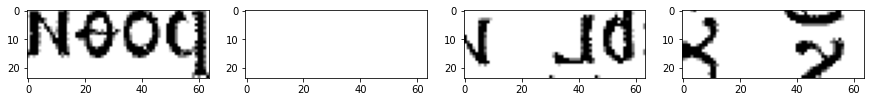

<h1>&nbsp;&nbsp;&nbsp;&nbsp;№04</h1>

Is this correct (y/n)?
n


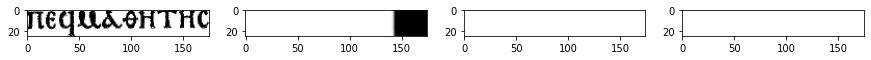

<h1>&nbsp;&nbsp;&nbsp;&nbsp;ПеЧидеНТиС</h1>

Is this correct (y/n)?
y


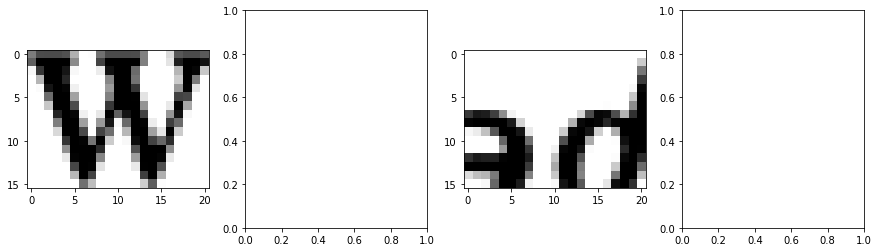

<h1>&nbsp;&nbsp;&nbsp;&nbsp;W</h1>

Is this correct (y/n)?
y


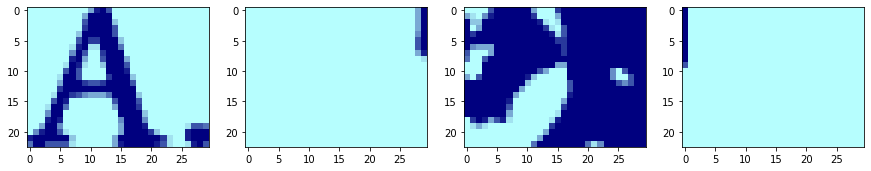

<h1>&nbsp;&nbsp;&nbsp;&nbsp;A.</h1>

Is this correct (y/n)?
y


In [ ]:
analysis = CrossTextAnalysis(TEXTS_ROOT, default_rng(17))
analysis.run(2)

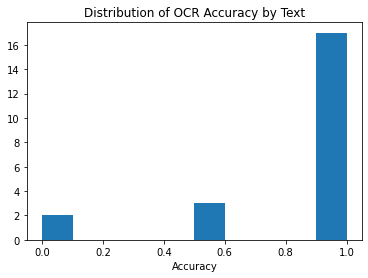

In [ ]:
analysis.hist()

## Analysis

This is the tedious part of this notebook. A human being has to manually assign a binary classification (correct/incorrect) to 2,200 image-word pairs.

In [ ]:
analysis = CrossTextAnalysis(TEXTS_ROOT, default_rng(42))
analysis.run(100)

Output hidden; open in https://colab.research.google.com to view.

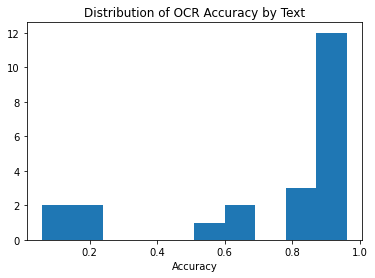

In [ ]:
analysis.hist()

In [ ]:
analysis.mean()

0.7181818181818183

In [ ]:
!ls

CorrectnessCheck.ipynb		  OCRDemo2.ipynb  tesseract_manager.py
correctness_check_results.pickle  __pycache__


In [ ]:
with open('correctness_check_results.pickle', 'wb') as dbfile:
  pickle.dump(analysis, dbfile, protocol=pickle.HIGHEST_PROTOCOL)

NameError: ignored

In [ ]:
analysis.accuracies()

[0.79,
 0.06,
 0.91,
 0.89,
 0.87,
 0.83,
 0.96,
 0.94,
 0.93,
 0.93,
 0.81,
 0.9,
 0.96,
 0.96,
 0.94,
 0.65,
 0.08,
 0.61,
 0.88,
 0.53,
 0.16,
 0.21]

In [ ]:
np.std(analysis.accuracies())

0.3015360126786662

It should be noted that there are in fact multiple ways to compute accuracies. This is how I chose to do it:
* Take 100 samples from each text. For each sample, do the following:
    1. Choose a page uniformly at random.
    2. Choose a word from that page uniformly at random.
This approach gives high weight to words that are in short texts and to words that are on sparse pages. However, it has the advantage of considering all texts equally and considering all pages within a given text equally. This makes sense because much of the variability in the data is on the document level or the page level.

## A CI for Accuracy

Here I do a quick bootstrap.

In [21]:
!ls

CorrectnessCheck.ipynb		  OCRDemo2.ipynb  tesseract_manager.py
correctness_check_results.pickle  __pycache__


In [22]:
with open('correctness_check_results.pickle', 'rb') as dbfile:
  analysis = pickle.load(dbfile)
accuracies = np.array(analysis.accuracies())
accuracies

array([0.79, 0.06, 0.91, 0.89, 0.87, 0.83, 0.96, 0.94, 0.93, 0.93, 0.81,
       0.9 , 0.96, 0.96, 0.94, 0.65, 0.08, 0.61, 0.88, 0.53, 0.16, 0.21])

In [23]:
estimates = np.zeros(100000)
random = default_rng(90009)
for i in range(100000):
  boot = random.choice(accuracies, len(accuracies), replace=True)
  estimates[i] = np.mean(boot)
(np.percentile(estimates, 2.5), np.percentile(estimates, 97.5))

(0.5845454545454546, 0.8354545454545454)

Here is a question: What would the confidence interval be if we had 400 samples?

In [24]:
estimates = np.zeros(10000)
random = default_rng(2314)
n_samples = 400
for i in range(10000):
  boot = random.choice(accuracies, n_samples, replace=True)
  estimates[i] = np.mean(boot)
(np.percentile(estimates, 2.5), np.percentile(estimates, 97.5))

(0.6887000000000001, 0.7479006249999999)

What about 100 samples?

In [25]:
estimates = np.zeros(10000)
random = default_rng(2314)
n_samples = 100
for i in range(10000):
  boot = random.choice(accuracies, n_samples, replace=True)
  estimates[i] = np.mean(boot)

(np.percentile(estimates, 2.5), np.percentile(estimates, 97.5))

(0.6565000000000001, 0.7759999999999999)

It is possible that my estimate of the standard error of our estimate was wrong, and that we may not actually need as many independent samples as I had thought. Here, I suggest a CI for the true STD.

In [26]:
estimates = np.zeros(10000)
random = default_rng(2314)
n_samples = 400
for i in range(10000):
  boot = random.choice(accuracies, n_samples, replace=True)
  estimates[i] = np.std(boot)
(np.percentile(estimates, 2.5), np.percentile(estimates, 97.5))

(0.2793278536496722, 0.32060210324520194)

Surprisingly, this CI is rather tight. (0.28, 0.32).

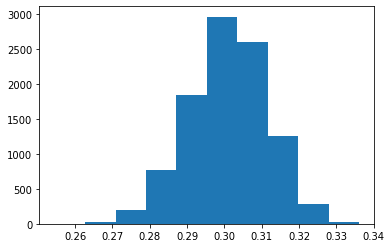

In [28]:
plt.hist(estimates);

These results are consistent with a back-of-the-envelope classical statistics approach of dividing the STD by the square root of the number of samples and then multiplying by 4.

This tells us how many sample texts we need in order to get a certain level of accuracy. If we want our 95% CI to be 0.06 wide, we need 400 samples. If we want it to be 0.12 wide, we can have 200 samples.

## Concluding Thoughts

* The performance of Pytesseract's orientation detection was underwhelming. In some cases, it correctly re-oriented pages that had been upside-down; in other cases, it failed to re-orient pages that were facing right, but was able to correctly read the pages anyway; and in at least one case, it incorrectly re-oriented a page, leading to an incorrect text output. It is an open question whether use of their orientation detection system is preferable to simply assuming that the orientation is always correct, as this is still just an informal first impression.
* The system apparently failed for Japanese and another script that I could not recognize.
    * I have no idea what the issue was for Japanese and I intend to look into it. It seemed like it had something to do with the segmentation -- the images that were supposed to correspond to words sometimes included both kanji and hiragana around it and sometimes included multiple hiragana characters when only one would be recognized.
    * The other language on which the system failed utterly looked like Greek and was recognized as Cyrillic. The issue of recognizing Greek as Cyrillic is one that I had previously noted and tried a workaround for. I compared this script to Greek, and I am actually still not sure what it is.
* Otherwise, a wide variety of scripts and diacritics were correctly identified.